In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import VerboseCallback
import shap
import pickle

import matplotlib
matplotlib.rcParams.update({"text.usetex": True, "font.family": "Times"})

In [20]:
# Read in the model parameters from the top of the data file
with open("../data/data.csv", "r") as f:
    params = dict([(param, float(val)) for (param, val) in [pair.split('=') for pair in f.readline().split(',')]])

In [21]:
# Read in the dataset from the CSV file
df = pd.read_csv("../data/data.csv", skiprows=1)

In [22]:
# Separate the dataset into the group, features, and target variable
grp = df["group"]
X = df.drop(columns=["group", "u"])
y = df["u"]

In [47]:
def MAAPE(y, y_pred):
    return np.mean(np.arctan2(np.abs(y - y_pred), np.abs(y)))
    
maape_scorer = make_scorer(MAAPE, greater_is_better=False)

maape_base = MAAPE(y, DummyRegressor(strategy="mean").fit(X, y).predict(X))
print("Baseline MAAPE score: ", maape_base)

Baseline MAAPE score:  0.7986209555010144


In [115]:
models = [
    {"model": Pipeline([("pf", PolynomialFeatures()), ("ss", StandardScaler()), ("ridge", Ridge(random_state=0))]),
     "search_space": {"pf__degree": Integer(1, 6), "ridge__alpha": Real(1e-5, 1e5, prior="log-uniform")},
     "name": "Polynomial Ridge"},
    {"model": RandomForestRegressor(n_estimators=10, random_state=0),
     "search_space": {"max_depth": Integer(1, 50), "max_samples": Real(0.01, 0.99, "uniform")},
     "name": "Random Forest"},
    {"model": AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=10, random_state=0),
     "search_space": {"base_estimator__max_depth": Integer(1, 50)},
     "name": "AdaBoost"},
    {"model": XGBRegressor(n_estimators=10, random_state=0),
     "search_space": {"max_depth": Integer(1, 50), "reg_alpha": Real(1e-8, 1e8, "log-uniform"), "reg_lambda": Real(1e-8, 1e8, "log-uniform")},
     "name": "XGBoost"}
]

In [116]:
n_iter = 100
for model in models:
    print("tuning hyperparameters for {}...".format(model["name"]))
    bs = BayesSearchCV(model["model"], model["search_space"], n_iter=n_iter, cv=GroupKFold(n_splits=5), 
                       return_train_score=True, random_state=0, scoring=maape_scorer)
    bs.fit(X, y, grp, VerboseCallback(n_iter))
    model["train_scores"] = (bs.cv_results_["mean_train_score"], bs.cv_results_["std_train_score"])
    model["valid_scores"] = (bs.cv_results_["mean_test_score"], bs.cv_results_["std_test_score"])
    model["best_params"] = bs.best_params_
    model["model"] = bs.best_estimator_
    print("best params: ", bs.best_params_)
    print("estimating accuracy...")
    model["test_scores"] = []
    for train_idx, test_idx in GroupKFold(n_splits=10).split(X, y, grp):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        model["model"].fit(X_train, y_train)
        y_pred = model["model"].predict(X_test)
        model["test_scores"].append(MAAPE(y_test, y_pred))

tuning hyperparameters for Polynomial Ridge...
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 0.6347
Function value obtained: 0.3370
Current minimum: 0.3370
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 0.1827
Function value obtained: 0.7332
Current minimum: 0.3370
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 0.5570
Function value obtained: 0.3317
Current minimum: 0.3317
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 0.1819
Function value obtained: 0.5959
Current minimum: 0.3317
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Tim

The objective has been evaluated at this point before.


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 2.2429
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 2.2827
Function value obtained: 0.2417
Current minimum: 0.2309
Iteration No: 17 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 2.3229
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 18 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 2.3591
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 19 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 2.4187
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1.8399
Function value obtained: 0.2656
Current minimum: 0.2309
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 2.0596
Function value obtained: 0.2657
Current minimum: 0.2309
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 2.5413
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.8618
Function value obtained: 0.2352
Current minimum: 0.2309
Iteration No: 24 started. Sea

The objective has been evaluated at this point before.


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 3.7185
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 70 started. Searching for the next optimal point.
Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 3.6720
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 71 started. Searching for the next optimal point.
Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 3.8930
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 72 started. Searching for the next optimal point.
Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 3.8668
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 73 started. Searching for the next optimal point.
Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 3.8065
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 74 started. Sea

The objective has been evaluated at this point before.


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 4.4163
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 87 started. Searching for the next optimal point.
Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 4.4633
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 88 started. Searching for the next optimal point.
Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 4.7939
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 89 started. Searching for the next optimal point.
Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 4.6849
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 90 started. Searching for the next optimal point.
Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 4.5652
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 91 started. Sea

The objective has been evaluated at this point before.


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 4.9346
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 92 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 5.3319
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 93 started. Searching for the next optimal point.
Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 5.0865
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 94 started. Searching for the next optimal point.
Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 5.0511
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 95 started. Searching for the next optimal point.
Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 5.0871
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 96 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 5.2105
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 97 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 5.4111
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 98 started. Searching for the next optimal point.
Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 5.0427
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 99 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 5.0029
Function value obtained: 0.2309
Current minimum: 0.2309
Iteration No: 100 started. Searching for the next optimal point.
Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 5.2830
Function value obtained: 0.2309
Current minimum: 0.2309
best params:  OrderedDict([('pf__degree', 6), ('ridge__alpha', 0.00010414015289642496)])
estimating accuracy...
tuning hyperparameters for Random Forest...
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 3.3033
Function value obtained: 0.1495
Current minimum: 0.1495
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 3.3712
Function value obtained: 0.1636
Current minimum: 0.1495
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 end

The objective has been evaluated at this point before.


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 7.7922
Function value obtained: 0.1442
Current minimum: 0.1439
Iteration No: 99 started. Searching for the next optimal point.
Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 7.7650
Function value obtained: 0.1445
Current minimum: 0.1439
Iteration No: 100 started. Searching for the next optimal point.
Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 8.0981
Function value obtained: 0.1442
Current minimum: 0.1439
best params:  OrderedDict([('max_depth', 44), ('max_samples', 0.9511258849012185)])
estimating accuracy...
tuning hyperparameters for AdaBoost...
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 6.0377
Function value obtained: 0.1409
Current minimum: 0.1409
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Sear

The objective has been evaluated at this point before.


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 7.2871
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 7.2754
Function value obtained: 0.1404
Current minimum: 0.1402
Iteration No: 36 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 7.1616
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 37 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 7.1322
Function value obtained: 0.1406
Current minimum: 0.1402
Iteration No: 38 started. Searching for the next optimal point.
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 7.2449
Function value obtained: 0.1404
Current minimum: 0.1402
Iteration No: 39 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 7.4589
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 40 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 7.2649
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 41 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 7.4568
Function value obtained: 0.1406
Current minimum: 0.1402
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 7.5197
Function value obtained: 0.1413
Current minimum: 0.1402
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 7.4310
Function value obtained: 0.1413
Current minimum: 0.1402
Iteration No: 44 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 7.3876
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 7.4218
Function value obtained: 0.1413
Current minimum: 0.1402
Iteration No: 46 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 7.5550
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 47 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 7.4782
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 48 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 7.7662
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 49 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 7.6659
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 50 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 7.3674
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 51 started. Searching for the next optimal point.
Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 7.4493
Function value obtained: 0.1413
Current minimum: 0.1402
Iteration No: 52 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 7.4471
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 53 started. Searching for the next optimal point.
Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 7.6787
Function value obtained: 0.1405
Current minimum: 0.1402
Iteration No: 54 started. Searching for the next optimal point.
Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 7.8936
Function value obtained: 0.1422
Current minimum: 0.1402
Iteration No: 55 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 7.7190
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 56 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 7.7888
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 57 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 7.9336
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 58 started. Searching for the next optimal point.
Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 3.9289
Function value obtained: 0.6027
Current minimum: 0.1402
Iteration No: 59 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 8.0667
Function value obtained: 0.1408
Current minimum: 0.1402
Iteration No: 60 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 7.8836
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 61 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 7.7421
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 62 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 8.2007
Function value obtained: 0.1413
Current minimum: 0.1402
Iteration No: 63 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 7.9397
Function value obtained: 0.1413
Current minimum: 0.1402
Iteration No: 64 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 7.9117
Function value obtained: 0.1413
Current minimum: 0.1402
Iteration No: 65 started. Searching for the next optimal point.
Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 5.5783
Function value obtained: 0.2152
Current minimum: 0.1402
Iteration No: 66 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 7.9262
Function value obtained: 0.1405
Current minimum: 0.1402
Iteration No: 67 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 8.0363
Function value obtained: 0.1404
Current minimum: 0.1402
Iteration No: 68 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 8.2829
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 69 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 8.3213
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 70 started. Searching for the next optimal point.
Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 7.5348
Function value obtained: 0.1525
Current minimum: 0.1402
Iteration No: 71 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 8.1142
Function value obtained: 0.1408
Current minimum: 0.1402
Iteration No: 72 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 8.2036
Function value obtained: 0.1405
Current minimum: 0.1402
Iteration No: 73 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 8.2511
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 74 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 8.4515
Function value obtained: 0.1405
Current minimum: 0.1402
Iteration No: 75 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 8.6753
Function value obtained: 0.1409
Current minimum: 0.1402
Iteration No: 76 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 8.1500
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 77 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 8.1628
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 78 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 8.2857
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 79 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 8.3697
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 80 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 8.3290
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 81 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 8.3840
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 82 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 8.4348
Function value obtained: 0.1405
Current minimum: 0.1402
Iteration No: 83 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 8.4572
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 84 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 9.0463
Function value obtained: 0.1413
Current minimum: 0.1402
Iteration No: 85 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 7.5734
Function value obtained: 0.1582
Current minimum: 0.1402
Iteration No: 86 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 8.4855
Function value obtained: 0.1405
Current minimum: 0.1402
Iteration No: 87 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 8.4861
Function value obtained: 0.1405
Current minimum: 0.1402
Iteration No: 88 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 8.4805
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 89 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 8.8488
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 90 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 9.0535
Function value obtained: 0.1404
Current minimum: 0.1402
Iteration No: 91 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 10.1719
Function value obtained: 0.1404
Current minimum: 0.1402
Iteration No: 92 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 9.3044
Function value obtained: 0.1405
Current minimum: 0.1402
Iteration No: 93 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 9.1916
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 94 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 10.3492
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 95 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 9.6830
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 96 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 9.4216
Function value obtained: 0.1402
Current minimum: 0.1402
Iteration No: 97 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 9.3605
Function value obtained: 0.1413
Current minimum: 0.1402
Iteration No: 98 started. Searching for the next optimal point.
Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 6.3545
Function value obtained: 0.3367
Current minimum: 0.1402
Iteration No: 99 started. Searching for the next optimal point.
Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 8.3534
Function value obtained: 0.1659
Current minimum: 0.1402
Iteration No: 100 started. Searching for the next optimal point.


The objective has been evaluated at this point before.


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 9.7818
Function value obtained: 0.1406
Current minimum: 0.1402
best params:  OrderedDict([('base_estimator__max_depth', 32)])
estimating accuracy...
tuning hyperparameters for XGBoost...
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 0.6986
Function value obtained: 0.4532
Current minimum: 0.4532
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 0.2230
Function value obtained: 0.8342
Current minimum: 0.4532
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 4.0479
Function value obtained: 0.1905
Current minimum: 0.1905
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next op

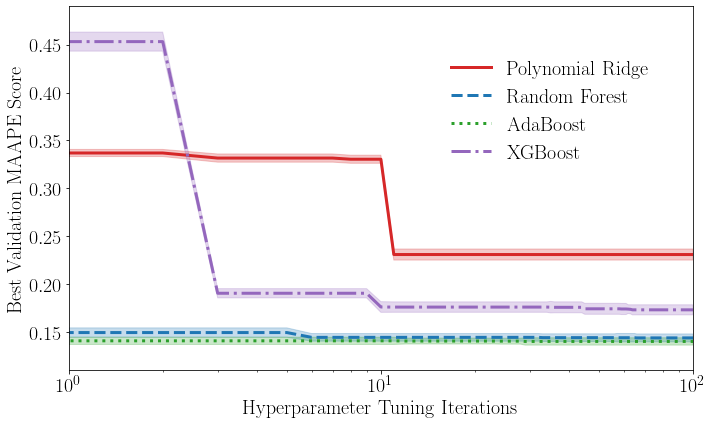

In [135]:
def argmax_accum(arr):
    idx = []
    for i, a in enumerate(arr):
        idx.append(i if not idx or a > arr[idx[-1]] else idx[-1])
    return idx

plt.figure(figsize=(10,6))
for model, color, ls in zip(models, ["tab:red", "tab:blue", "tab:green", "tab:purple"], ["-", "--", ":", "-."]):
    m = np.array(model["valid_scores"][0])
    s = np.array(model["valid_scores"][1])
    m = np.hstack((m[0], m))
    s = np.hstack((s[0], s))
    idx = argmax_accum(m)
    plt.fill_between(np.arange(len(m)), -m[idx] - s[idx], -m[idx] + s[idx], alpha=0.25, color=color)
    plt.plot(np.arange(len(m)), -m[idx], label=model["name"], color=color, ls=ls, lw=3)

plt.semilogx()
font = font_manager.FontProperties(size=20)
plt.legend(frameon=False, prop=font, loc=[0.6, 0.55], ncol=1)
plt.xlim(1, 100)
plt.ylim(0.11, 0.49)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Hyperparameter Tuning Iterations", fontsize=20)
plt.ylabel(u"Best Validation MAAPE Score", fontsize=20)
plt.tight_layout()
plt.savefig("../figures/model/train-convergence.pdf")

Polynomial Ridge is 57.35117260079909 standard deviations below the baseline
Random Forest is 99.65264477027596 standard deviations below the baseline
AdaBoost is 98.43535853077202 standard deviations below the baseline
XGBoost is 106.27983614318943 standard deviations below the baseline


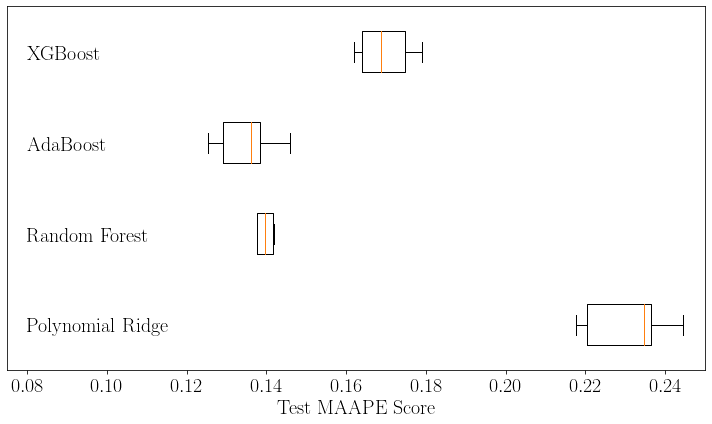

In [123]:
for model in models:
    num_std = (maape_base - np.max(model["test_scores"])) / np.std(model["test_scores"])
    print("{} is {} standard deviations below the baseline".format(model["name"], num_std))

plt.figure(figsize=(10,6))
plt.boxplot([model["test_scores"] for model in models], vert=False, labels=[model["name"] for model in models], showfliers=False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20, ha="left")
plt.tick_params(axis="y", pad=-20, length=0)
plt.xlabel(u"Test MAAPE Score", fontsize=20)
plt.xlim(0.075, 0.25)
plt.tight_layout()
plt.savefig("../figures/model/test-scores.pdf")

In [125]:
for model in models:
    if "n_estimators" in model["model"].get_params().keys():
        model["model"].set_params(n_estimators=100)
    model["model"].fit(X, y)
    
pickle.dump(models, open("trained-model.pkl", "wb"))

In [133]:
model = models[2]["model"]

explainer = shap.TreeExplainer(model)

np.random.seed(0)
X_shap = X.iloc[np.random.choice(len(X), 100, replace=False)]
shap_values = explainer.shap_values(X_shap)

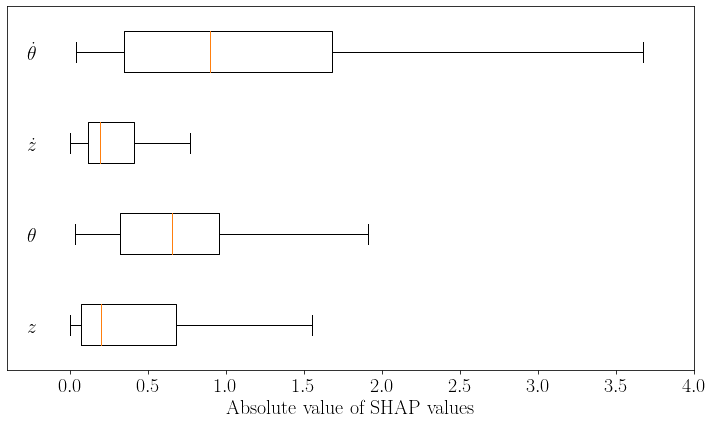

In [134]:
labels = {"z": r"$z$", "theta": r"$\theta$", "z_dot": r"$\dot{z}$", "theta_dot": r"$\dot{\theta}$"}

plt.figure(figsize=(10, 6))
plt.boxplot(np.abs(shap_values), vert=False, labels=[labels[col] for col in X_shap.columns], showfliers=False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20, ha="left")
plt.tick_params(axis="y", pad=-20, length=0)
plt.xlim(-0.4, 4)
plt.xlabel("Absolute value of SHAP values", fontsize=20)
plt.tight_layout()
plt.savefig("../figures/model/shap-values.pdf")